In [5]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
from scipy.stats import ks_2samp
import math
import mpl_style
import csv
import hex_scatter as hs

H0 = 72.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [6]:
hdulist1 = fits.open('../lookup_redpas.fits')
redpas_data = hdulist1[1].data
redpas_ind = redpas_data['redpas_ind']
redpas_pfeatures = redpas_data['redpas_pfeatures']
redpas_psmooth = redpas_data['redpas_psmooth']
redpas_color = redpas_data['redpas_color']
redpas_sfr = redpas_data['redpas_sfr']
redpas_mr = redpas_data['redpas_mr']
redpas_mass = redpas_data['redpas_mass']
redpas_galnum = redpas_data['redpas_galnum']

hdulist2 = fits.open('../lookup_redact.fits')
redact_data = hdulist2[1].data
redact_ind = redact_data['redact_ind']
redact_pfeatures = redact_data['redact_pfeatures']
redact_psmooth = redact_data['redact_psmooth']
redact_color = redact_data['redact_color']
redact_sfr = redact_data['redact_sfr']
redact_mr = redact_data['redact_mr']
redact_mass = redact_data['redact_mass']
redact_galnum = redact_data['redact_galnum']

hdulist3 = fits.open('../lookup_bluact.fits')
bluact_data = hdulist3[1].data
bluact_ind = bluact_data['bluact_ind']
bluact_pfeatures = bluact_data['bluact_pfeatures']
bluact_psmooth = bluact_data['bluact_psmooth']
bluact_color = bluact_data['bluact_color']
bluact_sfr = bluact_data['bluact_sfr']
bluact_mr = bluact_data['bluact_mr']
bluact_mass = bluact_data['bluact_mass']
bluact_galnum = bluact_data['bluact_galnum']

hdulist4 = fits.open('../lookup_all.fits')
all_data = hdulist4[1].data
halo_mass = all_data['halo_mass']
pfeatures = all_data['pfeatures']
psmooth = all_data['psmooth']
color = all_data['color']
ssfr = all_data['ssfr']
M_r = all_data['M_r']
mass = all_data['mass']
z = all_data['z']
centsat = all_data['centsat']
galaxy_num = all_data['galaxy_num']
group_num = all_data['group_num']

group_list = {}
with open('../lookup_group.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        introw = [int(i) for i in row]
        group_list[introw[0]] = introw[1:]

Above cell gets lists from lookup tables. Note that group_list is a dictionary with the group number as the key and a list of member IDs as the value

In [7]:
#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17
M_limit = m - 5*math.log(d.value,10) + 5 
adj_M_limit = M_limit - 5*math.log(h,10)

In this cell, we use group_list to calculate the average pspiral and ssfr of the satellites of each central

In [8]:
cent_pspiral = []
sat_pspiral_edit = [] #array of pspiral only for groups with centrals
sat_pspiral_all = [] #pspiral of satellites for all groups

cent_ssfr = []
sat_ssfr = []

LG_cent_ssfr_pas_sat = [] #ssfr of central galaxies with at least 3 satellites with less than 1/2 star forming fraction
LG_cent_ssfr_act_sat = [] #same as above but greater than 1/2 star forming fraction
LG_cent_pfeat_smooth_sat = [] #pfeatures of central galaxies with at least 3 satellites with less than 1/2 pfeatures fraction
LG_cent_pfeat_spiral_sat = [] #same as above but greater than 1/2 pfeatures fraction

AG_cent_ssfr_pas_sat = []
AG_cent_ssfr_act_sat = []
AG_cent_pfeat_smooth_sat = []
AG_cent_pfeat_spiral_sat = [] #these are the same as above but for groups of all sizes

frac_sat_spiral = []
frac_sat_sfing = []

for group, group_gals in group_list.iteritems():
    if len(group_gals) > 1: #remove single galaxy groups
        has_central = False
        sat_pfeatures_group = []
        sat_ssfr_group = []
        sat_spiral = 0
        sat_sfing = 0
        sat_num = 0
        
        for gal in group_gals: #now loop through these galaxies
            ind = np.where(galaxy_num == gal) #index to use in other arrays for this galaxy
            if centsat[ind[0][0]] == 1: #if its a central galaxy
                cent_ssfr.append(ssfr[ind[0][0]])
                cent_pspiral.append(pfeatures[ind[0][0]])
                has_central = True
            else: #satellite galaxy
                sat_num += 1
                sat_pfeatures_group.append(pfeatures[ind[0][0]])
                sat_ssfr_group.append(ssfr[ind[0][0]])
                if pfeatures[ind[0][0]] > 0.5:
                    sat_spiral += 1
                if ssfr[ind[0][0]] > (-10 + 0.094*(M_r[ind[0][0]] + 15)):
                    sat_sfing += 1
        sat_pspiral_all.append(np.mean(np.array(sat_pfeatures_group)))
        if len(sat_pfeatures_group) < 1:
            print group_gal
        if has_central == True:
            sat_pspiral_edit.append(np.mean(np.array(sat_pfeatures_group)))
            sat_ssfr.append(np.mean(np.array(sat_ssfr_group)))
            
            sf_frac = sat_sfing/sat_num
            spiral_frac = sat_spiral/sat_num
            
            frac_sat_spiral.append(spiral_frac)
            frac_sat_sfing.append(sf_frac)
            
            central_pfeat = cent_pspiral[-1]
            central_ssfr = cent_ssfr[-1]
            
            if sf_frac >= 0.5:
                AG_cent_ssfr_act_sat.append(central_ssfr)
            if sf_frac < 0.5:
                AG_cent_ssfr_pas_sat.append(central_ssfr)
            if spiral_frac >= 0.5:
                AG_cent_pfeat_spiral_sat.append(central_pfeat)
            if spiral_frac < 0.5:
                AG_cent_pfeat_smooth_sat.append(central_pfeat)
            if len(sat_pfeatures_group) > 2:
                if sf_frac >= 0.5:
                    LG_cent_ssfr_act_sat.append(central_ssfr)
                if sf_frac < 0.5:
                    LG_cent_ssfr_pas_sat.append(central_ssfr)
                if spiral_frac >= 0.5:
                    LG_cent_pfeat_spiral_sat.append(central_pfeat)
                if spiral_frac < 0.5:
                    LG_cent_pfeat_smooth_sat.append(central_pfeat)

/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


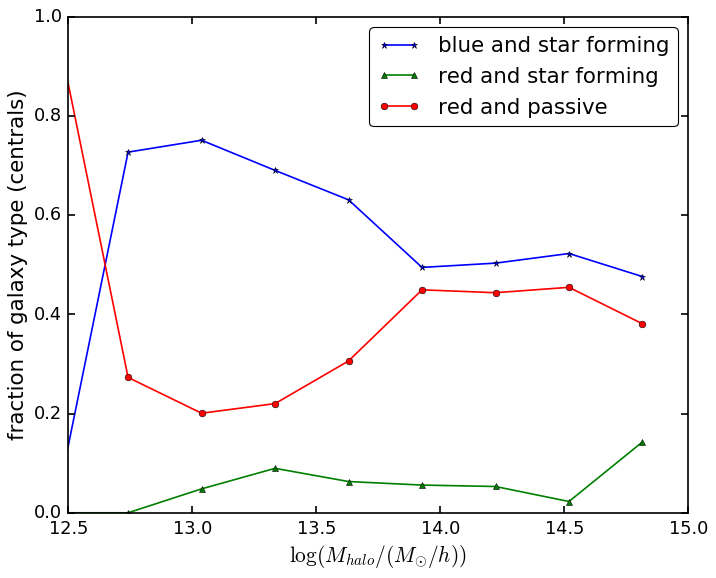

In [9]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_cent = [x[0] for x in bluact_ind if x[1]==1]
redact_ind_cent = [x[0] for x in redact_ind if x[1]==1]
redpas_ind_cent = [x[0] for x in redpas_ind if x[1]==1]

halo_mass = np.array(halo_mass)
bluact_halo_mass_cent = halo_mass[bluact_ind_cent]
redact_halo_mass_cent = halo_mass[redact_ind_cent]
redpas_halo_mass_cent = halo_mass[redpas_ind_cent]

bluact_hist,a = np.histogram(bluact_halo_mass_cent, bins=50)
redact_hist,b = np.histogram(redact_halo_mass_cent, bins=50)
redpas_hist,bin_edges = np.histogram(redpas_halo_mass_cent, bins=50)
all_hist = bluact_hist + redact_hist + redpas_hist

bluact_norm_hist = bluact_hist/all_hist
redact_norm_hist = redact_hist/all_hist
redpas_norm_hist = redpas_hist/all_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_norm_hist, c='b', marker='*', label='blue and star forming')
plt.plot(bin_edges_adj, redact_norm_hist, c='g', marker='^', label='red and star forming')
plt.plot(bin_edges_adj, redpas_norm_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (centrals)')
plt.xlabel(r'$\log (M_{halo}/ (M_{\odot}/h))$')
plt.xlim(12.5, 15)
#plt.ylim(0,1)

plt.show()

/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


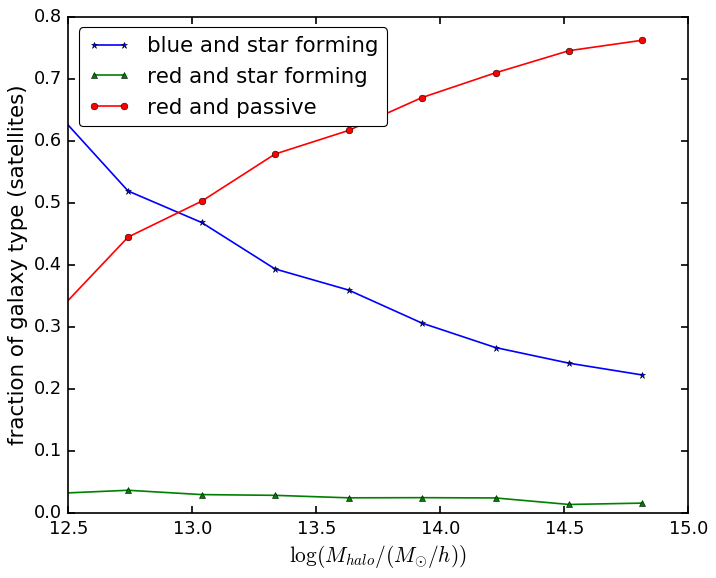

In [13]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_sat = [x[0] for x in bluact_ind if x[1]==2]
redact_ind_sat = [x[0] for x in redact_ind if x[1]==2]
redpas_ind_sat = [x[0] for x in redpas_ind if x[1]==2]

halo_mass = np.array(halo_mass)
bluact_halo_mass_sat = halo_mass[bluact_ind_sat]
redact_halo_mass_sat = halo_mass[redact_ind_sat]
redpas_halo_mass_sat = halo_mass[redpas_ind_sat]

bluact_hist,a = np.histogram(bluact_halo_mass_sat, bins=50)
redact_hist,b = np.histogram(redact_halo_mass_sat, bins=50)
redpas_hist,bin_edges = np.histogram(redpas_halo_mass_sat, bins=50)
all_hist = bluact_hist + redact_hist + redpas_hist

bluact_norm_hist = bluact_hist/all_hist
redact_norm_hist = redact_hist/all_hist
redpas_norm_hist = redpas_hist/all_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_norm_hist, c='b', marker='*', label='blue and star forming')
plt.plot(bin_edges_adj, redact_norm_hist, c='g', marker='^', label='red and star forming')
plt.plot(bin_edges_adj, redpas_norm_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (satellites)')
plt.xlabel(r'$\log (M_{halo}/ (M_{\odot}/h))$')
plt.xlim(12.5, 15)
#plt.ylim(0,1)

plt.show()

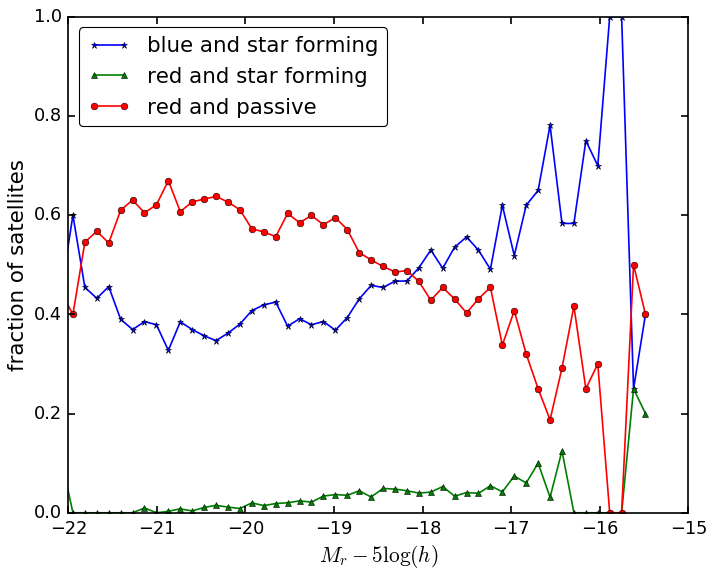

In [21]:
fig = plt.figure(figsize=(10,8))
bluact_mr_sat = [x[0] for x in bluact_mr if x[1]==2]
redact_mr_sat = [x[0] for x in redact_mr if x[1]==2]
redpas_mr_sat = [x[0] for x in redpas_mr if x[1]==2]
all_mr_sat = np.concatenate((bluact_mr_sat,redact_mr_sat,redpas_mr_sat))
plt.style.use(mpl_style.style1)

bluact_mr_hist,a = np.histogram(bluact_mr_sat, bins=50)
redact_mr_hist,b = np.histogram(redact_mr_sat, bins=50)
redpas_mr_hist,bin_edges = np.histogram(redpas_mr_sat, bins=50)
all_mr_hist = bluact_mr_hist + redact_mr_hist + redpas_mr_hist

bluact_mr_hist = bluact_mr_hist/all_mr_hist
redact_mr_hist = redact_mr_hist/all_mr_hist
redpas_mr_hist = redpas_mr_hist/all_mr_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_mr_hist, c='b', marker='*', label='blue and star forming')
plt.plot(bin_edges_adj, redact_mr_hist, c='g', marker='^', label='red and star forming')
plt.plot(bin_edges_adj, redpas_mr_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of satellites')
plt.xlabel(r'$M_r - 5\log(h)$')
plt.xlim(-22, -15)
plt.ylim(0,1)

plt.show()

p value of KS test on all centrals, low star-forming centrals: 0.0258332929717


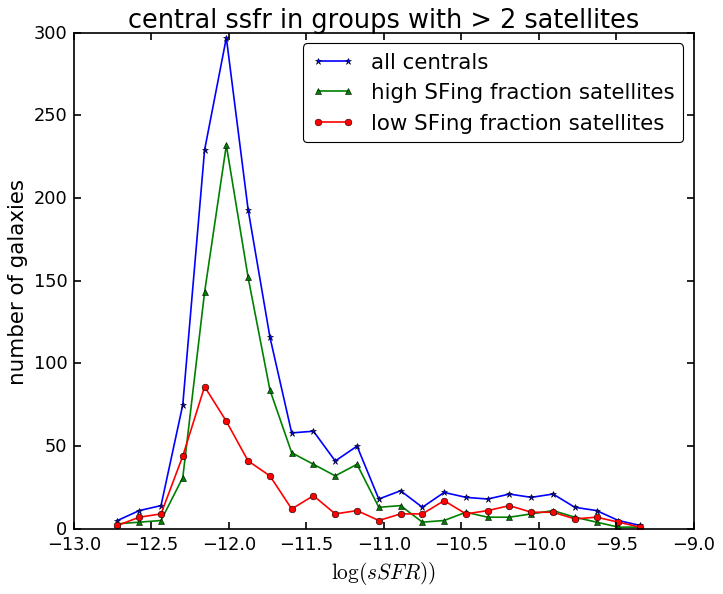

In [24]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_ssfr_pas_sat_hist_LG,b = np.histogram(LG_cent_ssfr_pas_sat, bins=25)
cent_ssfr_act_sat_hist_LG,bin_edges = np.histogram(LG_cent_ssfr_act_sat, bins=25)
cent_ssfr_hist_LG = cent_ssfr_pas_sat_hist_LG + cent_ssfr_act_sat_hist_LG

D, p_val = ks_2samp(cent_ssfr_hist_LG, cent_ssfr_pas_sat_hist_LG)
print('p value of KS test on all centrals, low star-forming centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_ssfr_hist_LG, c='b', marker='*', label='all centrals')
plt.plot(bin_edges_adj, cent_ssfr_pas_sat_hist_LG, c='g', marker='^', label='high SFing fraction satellites')
plt.plot(bin_edges_adj, cent_ssfr_act_sat_hist_LG, c='r', marker='o', label='low SFing fraction satellites')
plt.legend()
plt.title('central ssfr in groups with > 2 satellites')
plt.ylabel('number of galaxies')
plt.xlabel(r'$\log (sSFR))$')
#plt.xlim(12.5, 15)

plt.show()

p value of KS test on all centrals, low star-forming centrals: 0.0258332929717


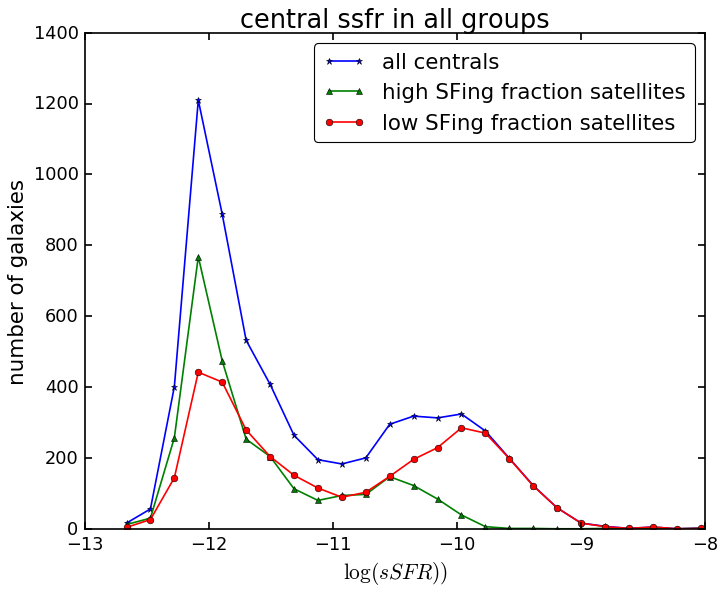

In [25]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_ssfr_pas_sat_hist,b = np.histogram(AG_cent_ssfr_pas_sat, bins=25)
cent_ssfr_act_sat_hist,bin_edges = np.histogram(AG_cent_ssfr_act_sat, bins=25)
cent_ssfr_hist = cent_ssfr_pas_sat_hist + cent_ssfr_act_sat_hist

D, p_val = ks_2samp(cent_ssfr_hist, cent_ssfr_pas_sat_hist)
print('p value of KS test on all centrals, low star-forming centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_ssfr_hist, c='b', marker='*', label='all centrals')
plt.plot(bin_edges_adj, cent_ssfr_pas_sat_hist, c='g', marker='^', label='high SFing fraction satellites')
plt.plot(bin_edges_adj, cent_ssfr_act_sat_hist, c='r', marker='o', label='low SFing fraction satellites')
plt.legend()
plt.title('central ssfr in all groups')
plt.ylabel('number of galaxies')
plt.xlabel(r'$\log (sSFR))$')
#plt.xlim(12.5, 15)

plt.show()

p value of KS test on all centrals, low pfeatures centrals: 0.648523991552


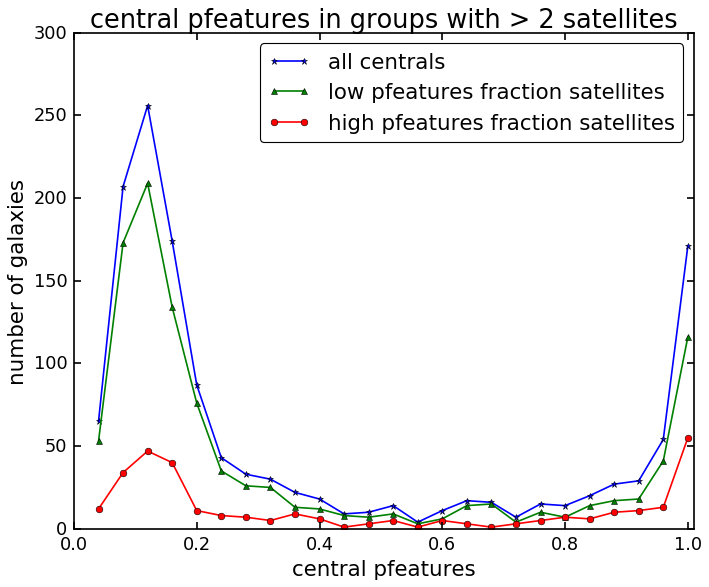

In [22]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_pfeat_smooth_sat_hist,b = np.histogram(LG_cent_pfeat_smooth_sat, bins=25)
cent_pfeat_spiral_sat_hist,bin_edges = np.histogram(LG_cent_pfeat_spiral_sat, bins=25)
cent_pfeat_hist = cent_pfeat_smooth_sat_hist + cent_pfeat_spiral_sat_hist

D, p_val = ks_2samp(cent_pfeat_hist, cent_pfeat_smooth_sat_hist)
print('p value of KS test on all centrals, low pfeatures centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_pfeat_hist, c='b', marker='*', label='all centrals')
plt.plot(bin_edges_adj, cent_pfeat_smooth_sat_hist, c='g', marker='^', label='low pfeatures fraction satellites')
plt.plot(bin_edges_adj, cent_pfeat_spiral_sat_hist, c='r', marker='o', label='high pfeatures fraction satellites')
plt.legend()
plt.title('central pfeatures in groups with > 2 satellites')
plt.ylabel('number of galaxies')
plt.xlabel('central pfeatures')
plt.xlim(0, 1.01)

plt.show()

p value of KS test on all centrals, low pfeatures centrals: 0.0012849158744


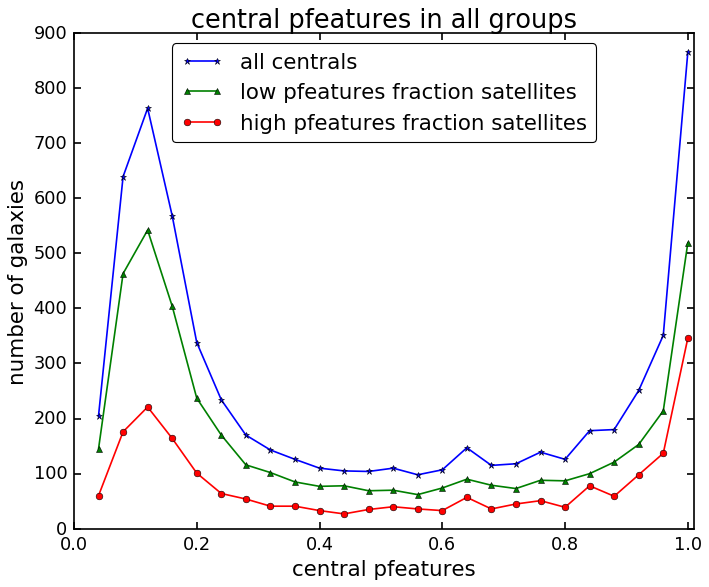

In [23]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_pfeat_smooth_sat_hist,b = np.histogram(AG_cent_pfeat_smooth_sat, bins=25)
cent_pfeat_spiral_sat_hist,bin_edges = np.histogram(AG_cent_pfeat_spiral_sat, bins=25)
cent_pfeat_hist = cent_pfeat_smooth_sat_hist+cent_pfeat_spiral_sat_hist

D, p_val = ks_2samp(cent_pfeat_hist, cent_pfeat_smooth_sat_hist)
print('p value of KS test on all centrals, low pfeatures centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_pfeat_hist, c='b', marker='*', label='all centrals')
plt.plot(bin_edges_adj, cent_pfeat_smooth_sat_hist, c='g', marker='^', label='low pfeatures fraction satellites')
plt.plot(bin_edges_adj, cent_pfeat_spiral_sat_hist, c='r', marker='o', label='high pfeatures fraction satellites')
plt.legend()
plt.title('central pfeatures in all groups')
plt.ylabel('number of galaxies')
plt.xlabel('central pfeatures')
plt.xlim(0, 1.01)

plt.show()

6290


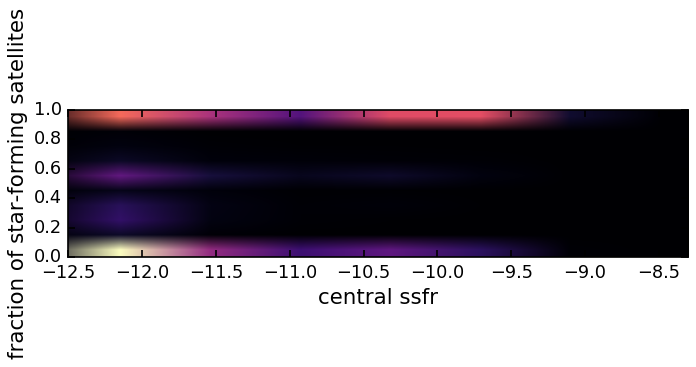

In [21]:
plt.style.use(mpl_style.style1)
plt.figure(figsize=(10,20))
hist, xedges, yedges = np.histogram2d(frac_sat_sfing,cent_ssfr, 10)
print(len(cent_ssfr))
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(frac_sat_sfing), np.max(frac_sat_sfing)])
#plt.scatter(cent_ssfr, frac_sat_sfing)
plt.xlabel('central ssfr')
plt.ylabel('fraction of star-forming satellites')
plt.ylim(0,1)
plt.xlim(-12.5,-8.3)
plt.show()

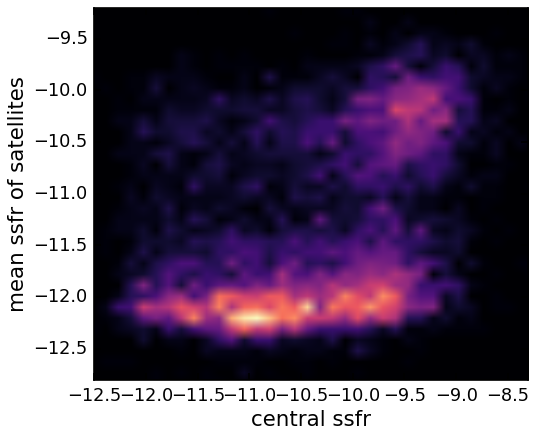

In [10]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_ssfr, sat_ssfr, 50)
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(sat_ssfr), np.max(sat_ssfr)])
#plt.scatter(cent_ssfr, sat_ssfr)
plt.xlabel('central ssfr')
plt.ylabel('mean ssfr of satellites')
plt.ylim(-12.8,-9.2)
plt.xlim(-12.5,-8.3)
plt.show()

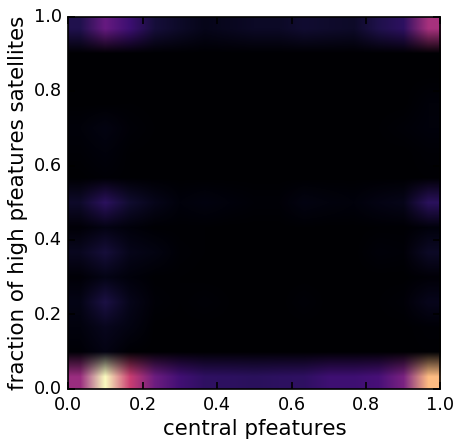

In [22]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(frac_sat_spiral, cent_pspiral, 15)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(frac_sat_spiral), np.max(frac_sat_spiral)])

#plt.scatter(cent_pspiral, frac_sat_spiral)
plt.xlabel('central pfeatures')
plt.ylabel('fraction of high pfeatures satellites')
plt.show()

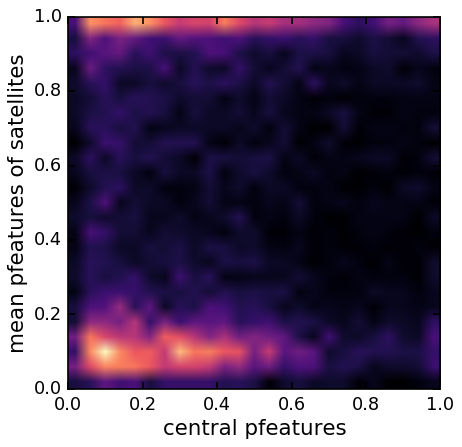

In [13]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_pspiral, sat_pspiral_edit, 25)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(sat_pspiral_edit), np.max(sat_pspiral_edit)])

#plt.scatter(cent_pspiral, sat_pspiral_edit)
plt.xlabel('central pfeatures')
plt.ylabel('mean pfeatures of satellites')
plt.show()

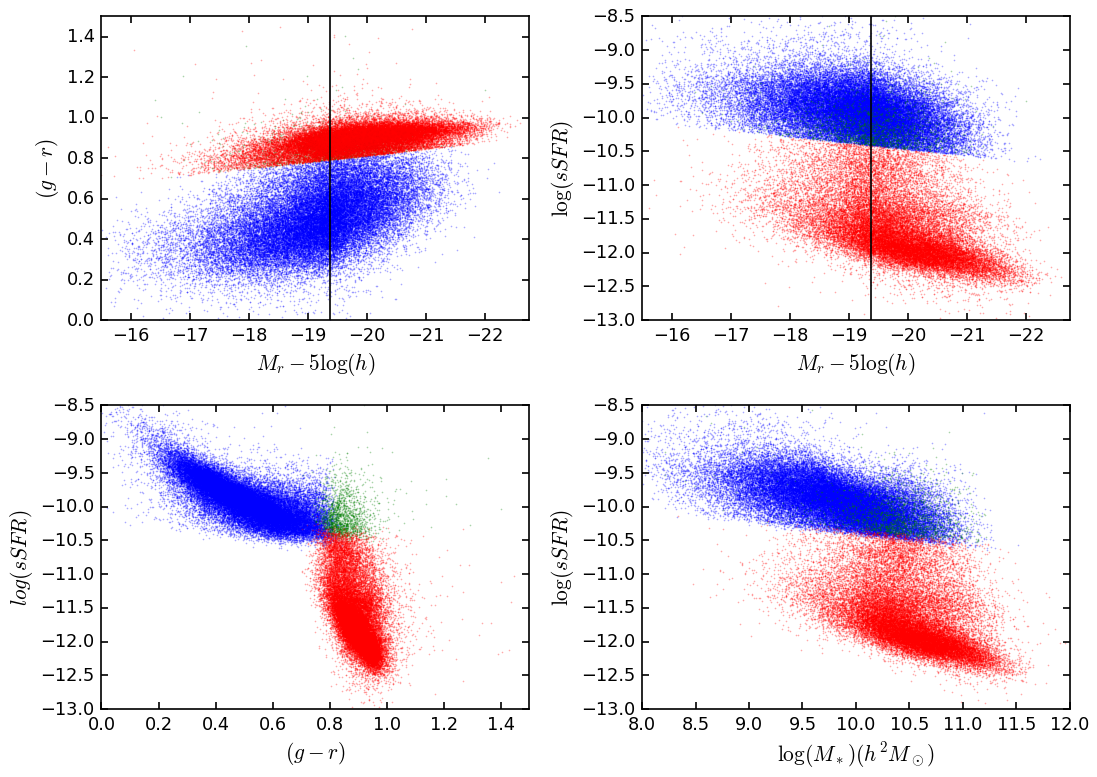

In [14]:
fig = plt.figure(figsize=(14,10))

colors = [[x[0] for x in bluact_color], [x[0] for x in redact_color], [x[0] for x in redpas_color]] #this method gets the first element of the tuples
mrs = [[x[0] for x in bluact_mr], [x[0] for x in redact_mr], [x[0] for x in redpas_mr]]
sfrs = [[x[0] for x in bluact_sfr], [x[0] for x in redact_sfr], [x[0] for x in redpas_sfr]]
masses = [[x[0] for x in bluact_mass], [x[0] for x in redact_mass], [x[0] for x in redpas_mass]]
plot_color = ['b', 'g', 'r']
plt.style.use(mpl_style.style1)
#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs[i], colors[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax1.set_ylabel(r'$(g-r)$')
ax1.set_xlabel(r'$M_r - 5\log(h)$')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(mrs[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax2.set_ylabel(r'$\log(sSFR)$')
ax2.set_xlabel(r'$M_r - 5\log(h)$')
ax2.set_ylim(-13, -8.5)
ax2.set_xlim(-15.5, -22.75)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax3.set_ylabel(r'$log(sSFR)$')
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylim(-13, -8.5)
ax3.set_xlim(0,1.5)

#bottom right plot
ax4 = fig.add_subplot(224)
for i in np.arange(3):
    ax4.scatter(masses[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax4.set_xlabel(r'$\log(M_*) (h^2 M_\odot)$')
ax4.set_ylabel(r'$\log(sSFR)$')
ax4.set_ylim(-13, -8.5)
#ax4.set_xscale('log')
ax4.set_xlim(8, 12)
#ax3.set_xlim(0,1.5)

plt.tight_layout()
plt.show()

In [1]:
plt.hist(redpas_pfeatures, 25, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_pfeatures, 25, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_pfeatures, 25, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.style.use(mpl_style.style1)

#plt.xlim(0,1)
plt.show()

fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_pfeat_smooth_sat_hist,b = np.histogram(redpas_pfeatures, bins=25)
cent_pfeat_spiral_sat_hist,bin_edges = np.histogram(bluact_pfeatures, bins=25)
cent_pfeat_hist = cent_pfeat_smooth_sat_hist+cent_pfeat_spiral_sat_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_pfeat_hist, c='b', marker='*', label='all centrals')
plt.plot(bin_edges_adj, cent_pfeat_smooth_sat_hist, c='g', marker='^', label='low pfeatures fraction satellites')
plt.plot(bin_edges_adj, cent_pfeat_spiral_sat_hist, c='r', marker='o', label='high pfeatures fraction satellites')
plt.legend()
plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures')
plt.legend(loc='upper right')
plt.xlim(0, 1.01)

#plt.show()

NameError: name 'plt' is not defined